# Stock Prediction Using Data From Yahoo Finance

### Table of contents 
1. Acknowledgments
2. Imports
2. EDA
3. Feature Engineering
1. Base line: prices are the same as the year before.
2. Linear model
3. Polynomial models
3. KNN
4. CNN
4. LSTM

#### Acknowledgements:
- https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
- https://towardsdatascience.com/keep-it-simple-keep-it-linear-a-linear-regression-model-for-time-series-5dbc83d89fc3

#### Import and Function defenitions

In [106]:
from pandas_datareader import data as web
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
import seaborn as sns
from math import sqrt
import pandas as pd
import numpy as np
import IPython
import IPython.display

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error,\
    mean_absolute_percentage_error, mean_absolute_error

import prophet
import tensorflow as tf
from fbprophet import Prophet

import math
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
yf.pdr_override()

In [107]:
def get_data(ticker):
    """
    INPUT: ticker - (str) ticker of a stock to be predicted
    
    OUTPUT: data - (pandas dataframe) dataframe with stock price info. 
            Includes following columns: 
                - Open
                - High
                - Low
                - Close
                - Adj Close
                - Volume
    """
    
    today = date.today()
    
    data = web.get_data_yahoo(ticker, end = today)
    
    return data

In [108]:
def line_plot(df, col_name, title):
    """
    INPUT: df - (pandas dataframe) dataframe that contains data to be ploted
           col_name - (string) column to be ploted
           ticker - (string) company stock ticker 

    OUTPUT: N/A
    """
    plt.figure(figsize=(14, 8))
    df[col_name].plot()
    plt.xlabel("Date")
    plt.ylabel(col_name)
    plt.title(title)
    plt.show()

In [109]:
def compute_errors(y_test, predictions):
    """
    INPUT: y_test - (list) prediction values
           predictions - (list) prediction values

    OUTPUT: print MSE, RMSE, MAPE
    """
    # Compute errors
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, predictions)

    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('MAPE:', mape)

## Get the Data

At this step I will get user input for the ticker and load coresponding stock prices data from Yahoo Finance.

In [110]:
# Enter a ticker
# Example: AAPl for Apple, AMZN for Amazon

ticker = input()

AAPL


In [111]:
# load the data
try:
    df = get_data(ticker)
except Exception:
    print('Data can not be loaded. Please check your ticker and try again')

[*********************100%***********************]  1 of 1 completed


In [112]:
# subset the dataset
df = df[df.index > '1999-12-31']

## Data Exploration

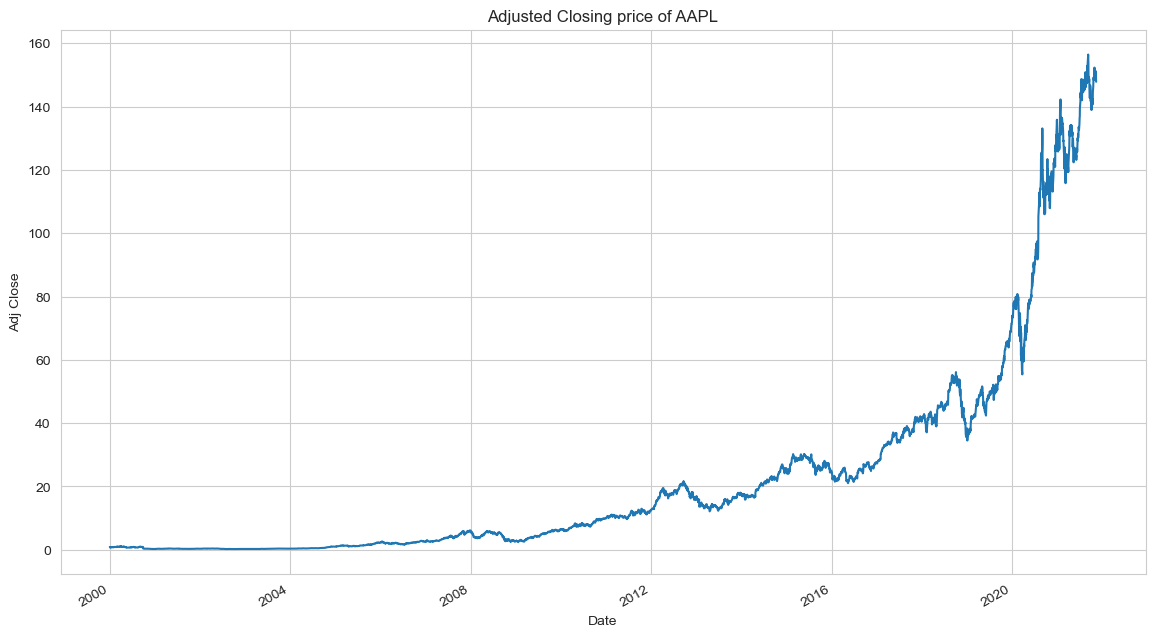

In [113]:
# plot closing price column (value we will try to predict)
line_plot(df, 'Adj Close', "Adjusted Closing price of {}".format(ticker))

We can see a significant spike that started at the end of 2019 and continued through the pandemic. This is indicative of possible difficulties in predicting future prices. 

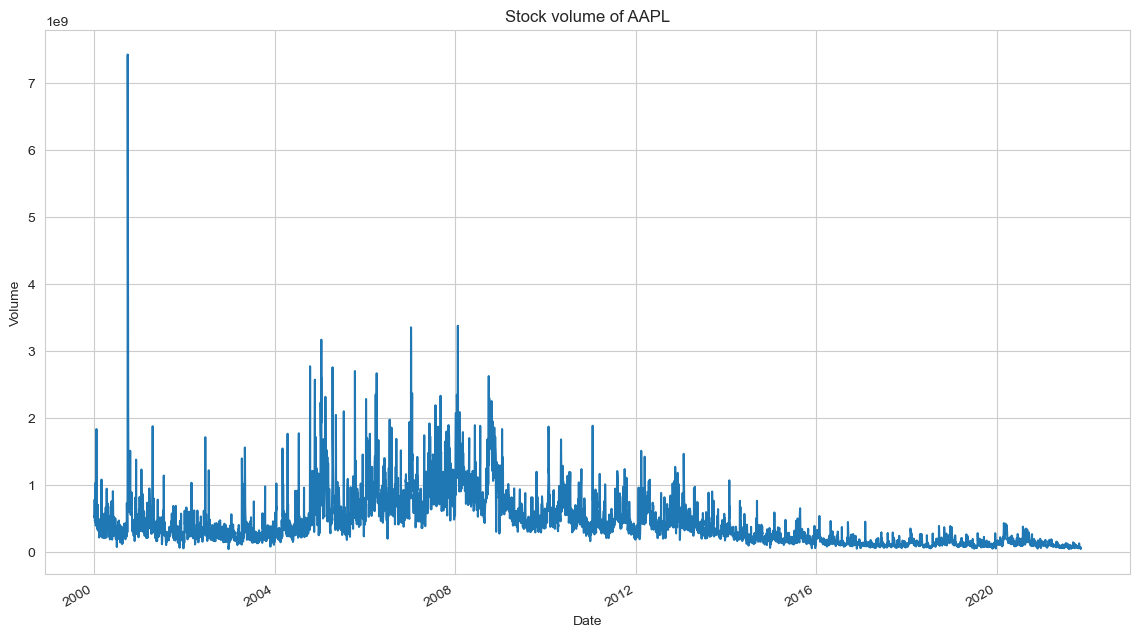

In [114]:
# plot stock volume
line_plot(df, 'Volume', 'Stock volume of {}'.format(ticker))

We can see that the volume traded became smaller and less volatile.

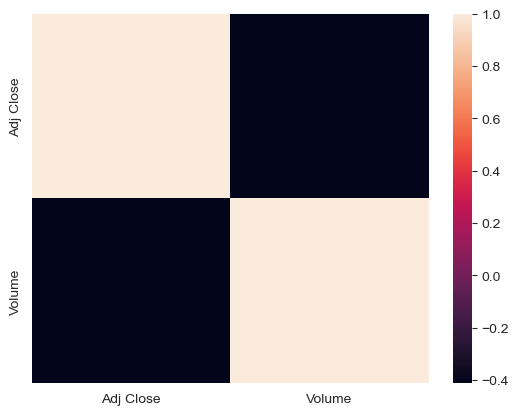

In [115]:
sns.heatmap(df[['Adj Close', 'Volume']].corr())
plt.show()

## Feature Engineering

Reference: https://alphascientist.com/feature_engineering.html

In [116]:
df.loc[:, 'ticker'] = ticker
df.loc[:, 'HL_PCT'] = ((df['High'] - df['Low']) / df['Adj Close'] * 100).values
df.loc[:, 'PCT_change'] = ((df['Adj Close'] - df['Open']) / df['Open'] * 100.0).values
df.loc[:, 'Daily_return'] = df['Adj Close'] / df['Open'] - 1

# Logarithmic transformation
df.loc[:, 'Volume'] = df['Volume'].apply(np.log)

# Differencing
df.loc[:, 'Change_1'] = df['Volume'].diff()
df.loc[:, 'Change_50'] = df['Volume'].diff(50)

# Moving Averages
# log of 5 day ma of volume
ma_5 = lambda x: x.rolling(5).mean()
df.loc[:, 'ma_5'] = df.groupby(by='ticker')['Volume'].apply(ma_5).apply(np.log)

# daily volume vs 200 day ma
ma_200 = lambda x: x.rolling(200).mean()
df.loc[:, 'ma_200'] = df['Volume'] / df.groupby(by='ticker')['Volume'].apply(ma_200) - 1

# daily closing price vs 50 day exponential ma
ema_50 = lambda x: x.ewm(span=50).mean()
df.loc[:, 'ema_50'] = df['Adj Close'] / df.groupby(by='ticker')['Adj Close'].apply(ema_50) - 1

# Z-Scores
zscore_fxn = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/x.rolling(window=200, min_periods=20).std()
df.loc[:, 'z_score'] = df.groupby(by='ticker')['Adj Close'].apply(zscore_fxn)

# signing: volume increased or decreased? 
df.loc[:, 'volume_sign'] = df['PCT_change'].apply(np.sign)

# how many days in a raw a value has increased / decreased
plus_minus_fn = lambda x: x.rolling(20).sum()
df.loc[:, 'days_vol_increased'] = df.groupby(by='ticker')['volume_sign'].apply(plus_minus_fn)



/Users/my_love/opt/anaconda3/envs/predict-stocks/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/my_love/opt/anaconda3/envs/predict-stocks/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [117]:
# One-Hot Encoding for month
month_of_year = df.index.get_level_values(level='Date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = df.index

# create column names
columns = month = ["Jan", "Feb", "Mar", "Apr", 
                   "May", "Jun", "Jul","Aug", 
                   "Sep", "Oct", "Nov", "Dec"]

one_hot_frame.columns = columns
df = df.join(one_hot_frame)

# Weekday features
weekdays = pd.Series(df.index)
dummy = pd.get_dummies(weekdays.dt.dayofweek.values)
dummy.index = df.index

dummy.columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

df = df.join(dummy)

In [118]:
# drop columns that we know are not necessary
df_new = df.drop(columns=['Close', 'ticker'])
df_new.head()

,Open,High,Low,Adj Close,Volume,HL_PCT,PCT_change,Daily_return,Change_1,Change_50,...,Aug,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.856887,20.099266,11.266372,-8.489828,-0.084898,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2000-01-04,0.966518,0.987723,0.903460,0.784643,20.054572,10.739026,-18.817592,-0.188176,-0.044693,NaN,...,0,0,0,0,0,0,1,0,0,0
2000-01-05,0.926339,0.987165,0.919643,0.796125,20.472650,8.481335,-14.056890,-0.140569,0.418078,NaN,...,0,0,0,0,0,0,0,1,0,0
2000-01-06,0.947545,0.955357,0.848214,0.727229,20.459265,14.733053,-23.251237,-0.232512,-0.013385,NaN,...,0,0,0,0,0,0,0,0,1,0
2000-01-07,0.861607,0.901786,0.852679,0.761677,19.948332,6.447221,-11.598066,-0.115981,-0.510933,NaN,...,0,0,0,0,0,0,0,0,0,1


Check Nan Values:

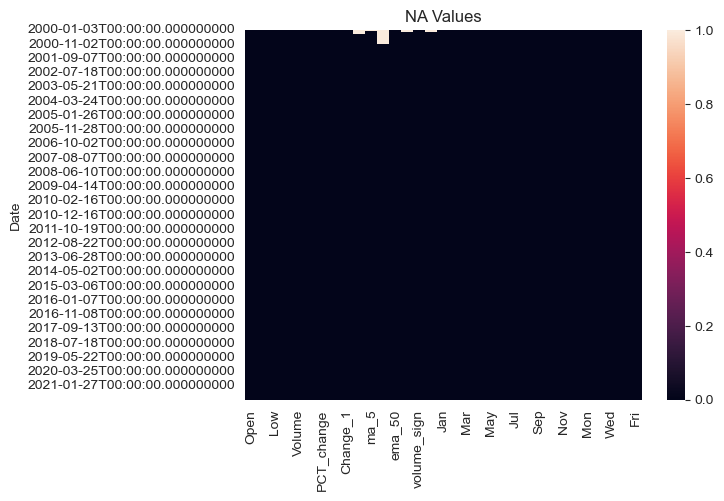

In [119]:
# visualize the existance of NA values
ax = plt.axes()
sns.heatmap(df_new.isna(), ax = ax)
ax.set_title('NA Values')
plt.show()

As we can see there are a couple of NA values. 

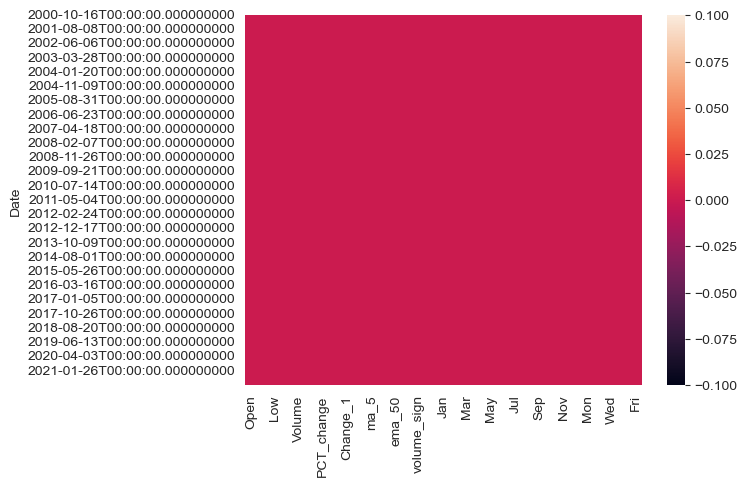

In [15]:
# drop NA values and visualize the result
df_new = df_new.dropna()
sns.heatmap(df_new.isna())
plt.show()

There are no more NA values.

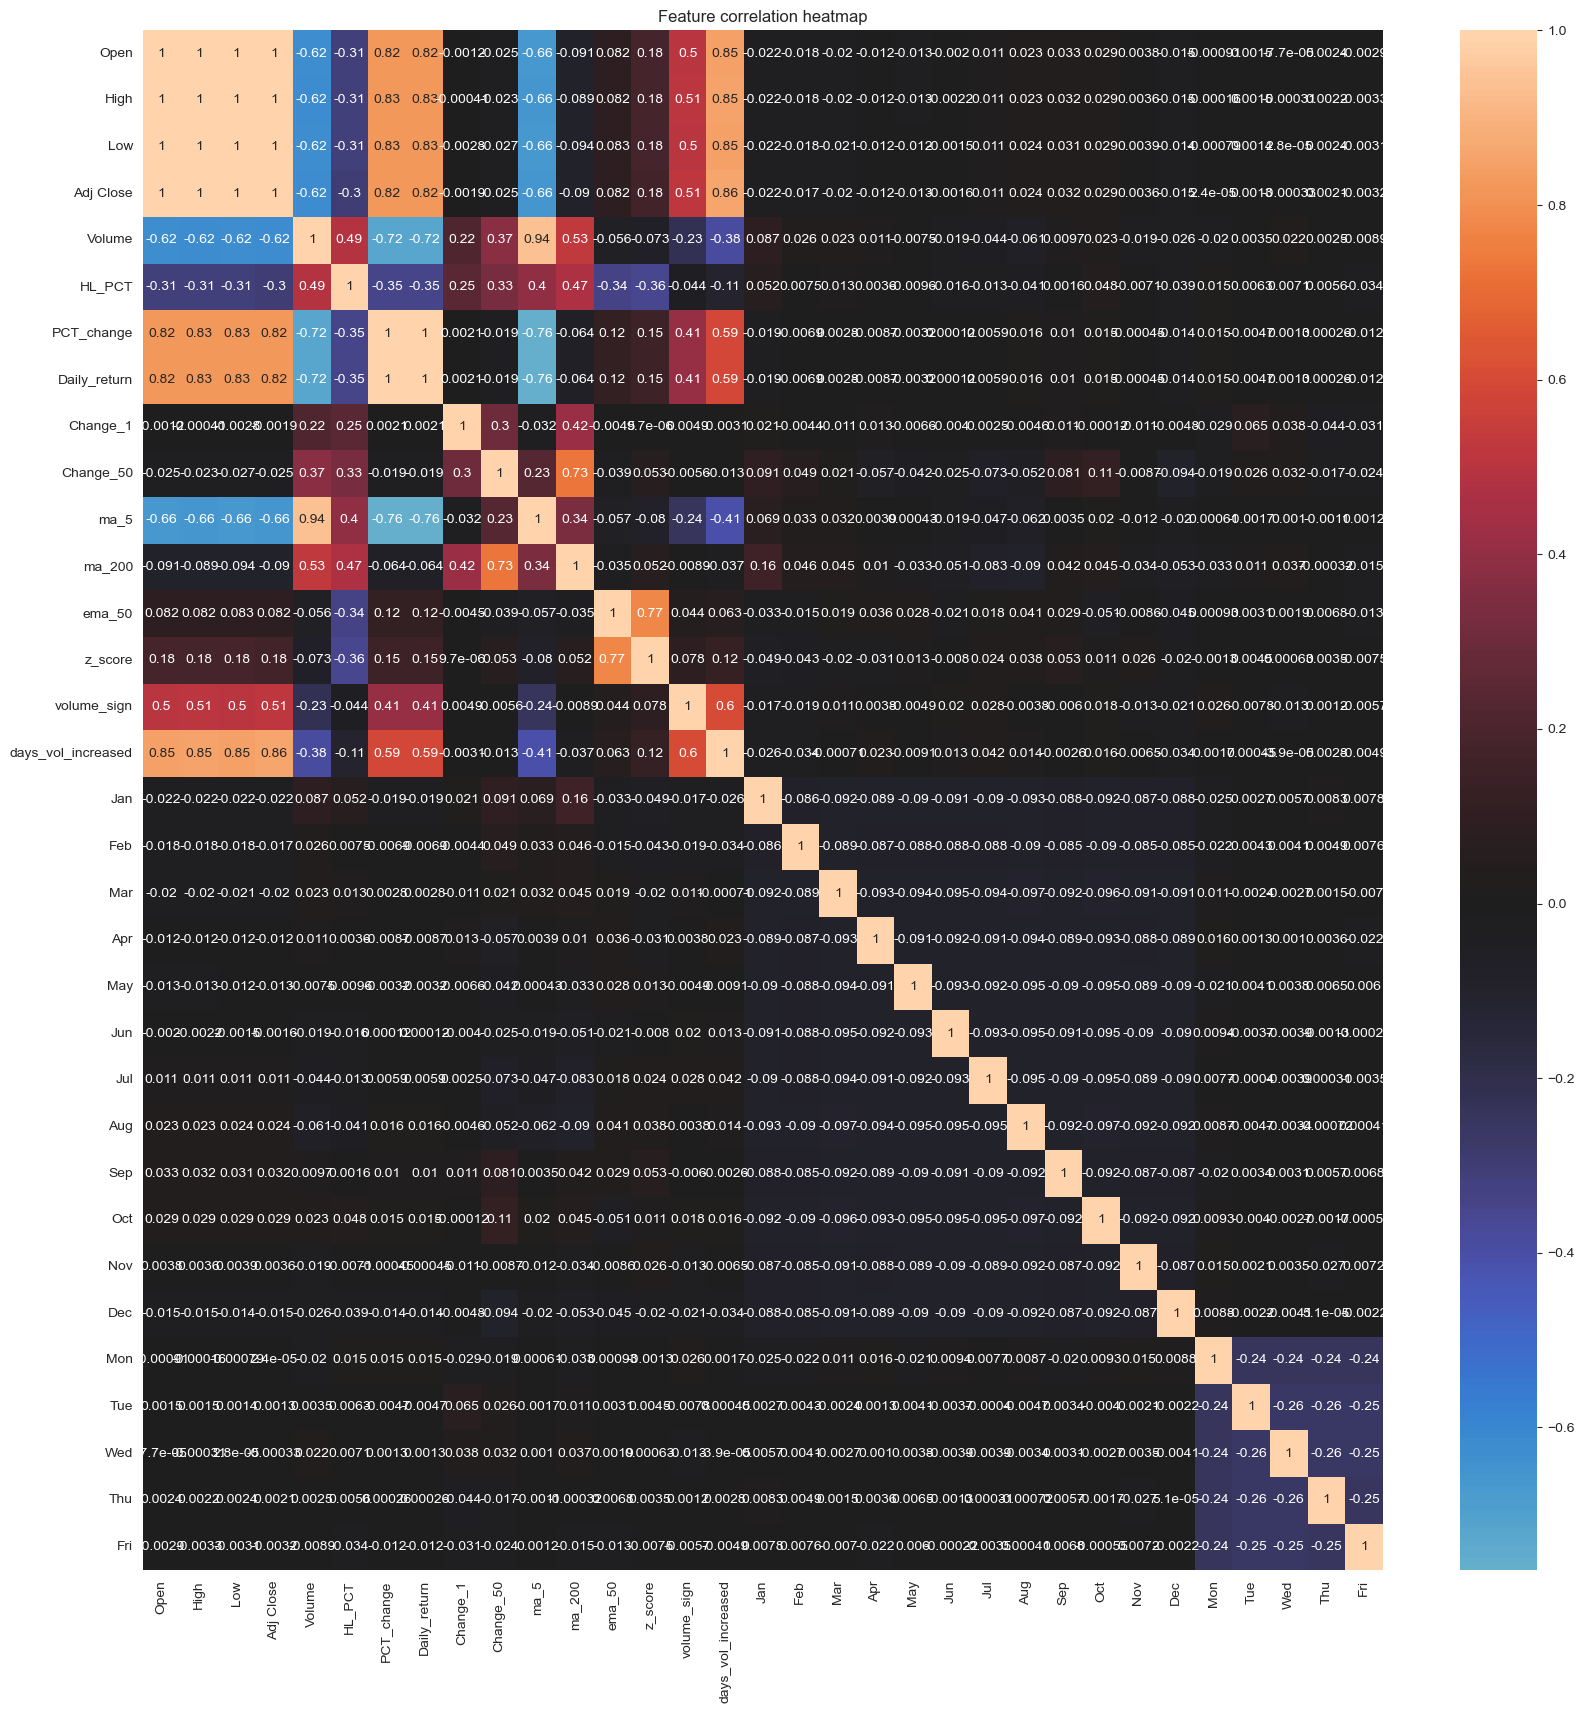

In [120]:
# Visualize the correlation of newly created features
plt.figure(figsize = (20,20))
ax = plt.axes()
sns.heatmap(df_new.corr(), ax = ax, annot=True, center=0)
ax.set_title('Feature correlation heatmap')
plt.show()

As we can see there a couple of highly correlated features. To avoid unexpected behavior (ex: multicolinearity) we should drop some of them.

In [17]:
df_new = df_new.drop(columns=['Open', 'Low', 'High', 'z_score', 'Volume', 'Daily_return'])

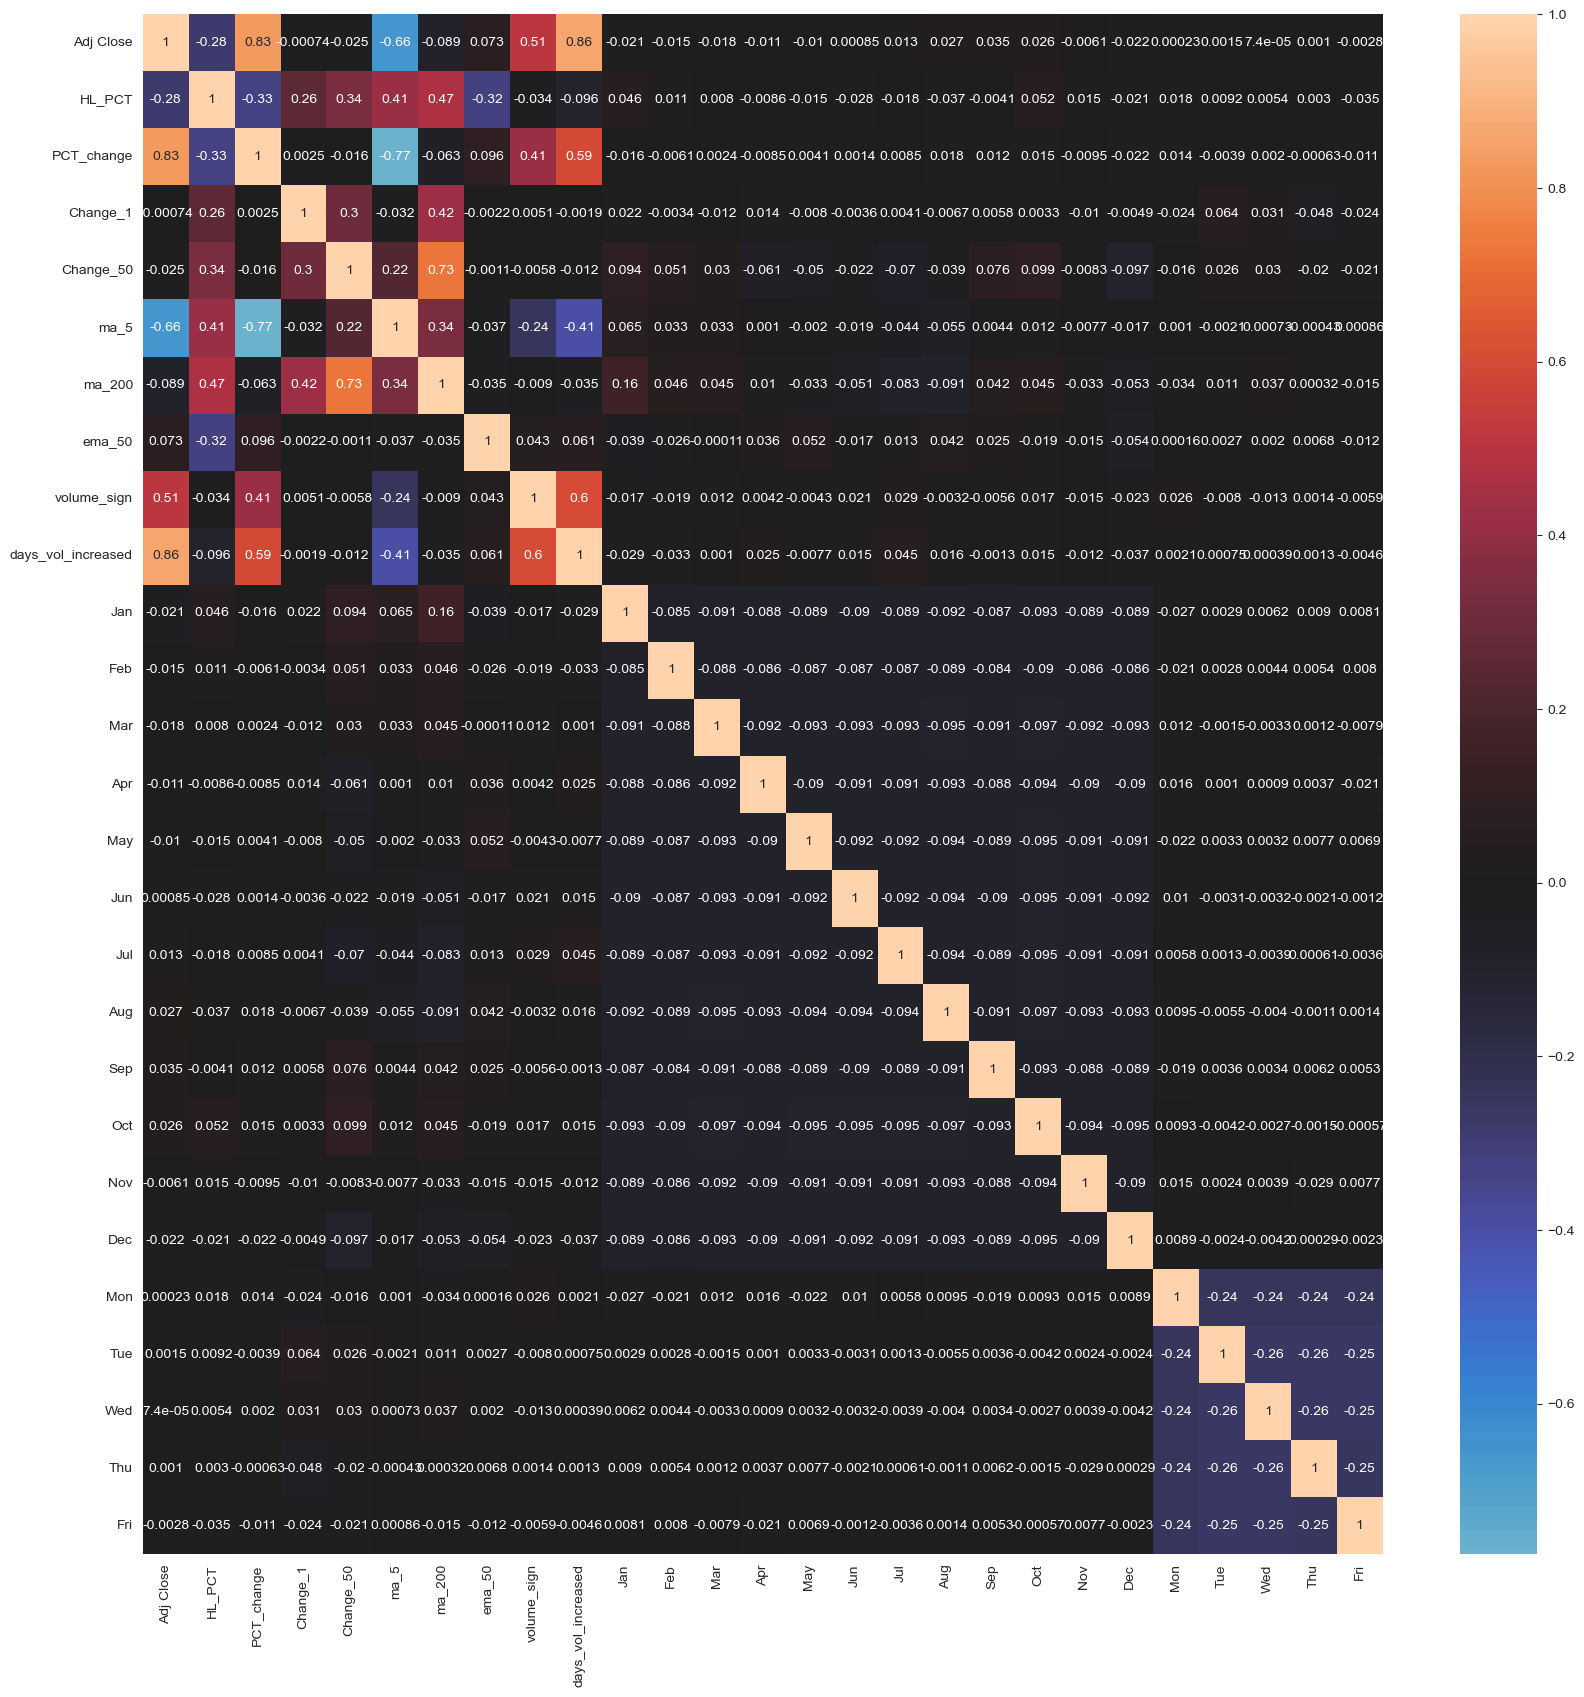

In [18]:
# Visualize feature correlations again
plt.figure(figsize = (20,20))
sns.heatmap(df_new.corr(), annot=True, center=0)
plt.show()

Looks much better.
Now, as we have our features ready, we can start preparing the data for the forecasting model.

## Train test split

In [19]:
n = len(df_new)                              # total number of data smaples
num_features = df_new.shape[1]               # total number of features

df_train = df_new[0:int(n * 0.7)]            # set first 70% of data as training data
df_val = df_new[int(n * 0.7):int(n * 0.9)]   # next 20% as validation data
df_test = df_new[int(n * 0.9):]              # last 10% of data will be our test data

#Note: we are not randomizing our split because we are working with TS data

df_train.head()

,Adj Close,HL_PCT,PCT_change,Change_1,Change_50,ma_5,ma_200,ema_50,volume_sign,days_vol_increased,...,Aug,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-16,0.329167,10.172037,-17.385543,-0.419581,1.136903,3.031349,0.039217,-0.490891,-1.0,-20.0,...,0,0,1,0,0,1,0,0,0,0
2000-10-17,0.308116,13.039915,-20.440536,-0.309727,1.166824,3.030011,0.023505,-0.513460,-1.0,-20.0,...,0,0,1,0,0,0,1,0,0,0
2000-10-18,0.308116,13.402448,-11.230973,0.326760,1.552243,3.026505,0.039920,-0.503459,-1.0,-20.0,...,0,0,1,0,0,0,0,1,0,0
2000-10-19,0.289935,9.238616,-15.242461,0.591142,1.378468,3.028782,0.069668,-0.522784,-1.0,-20.0,...,0,0,1,0,0,0,0,0,1,0
2000-10-20,0.298546,8.597995,-12.295924,-0.644063,1.145336,3.024366,0.037060,-0.498607,-1.0,-20.0,...,0,0,1,0,0,0,0,0,0,1


## Scaling Training Data

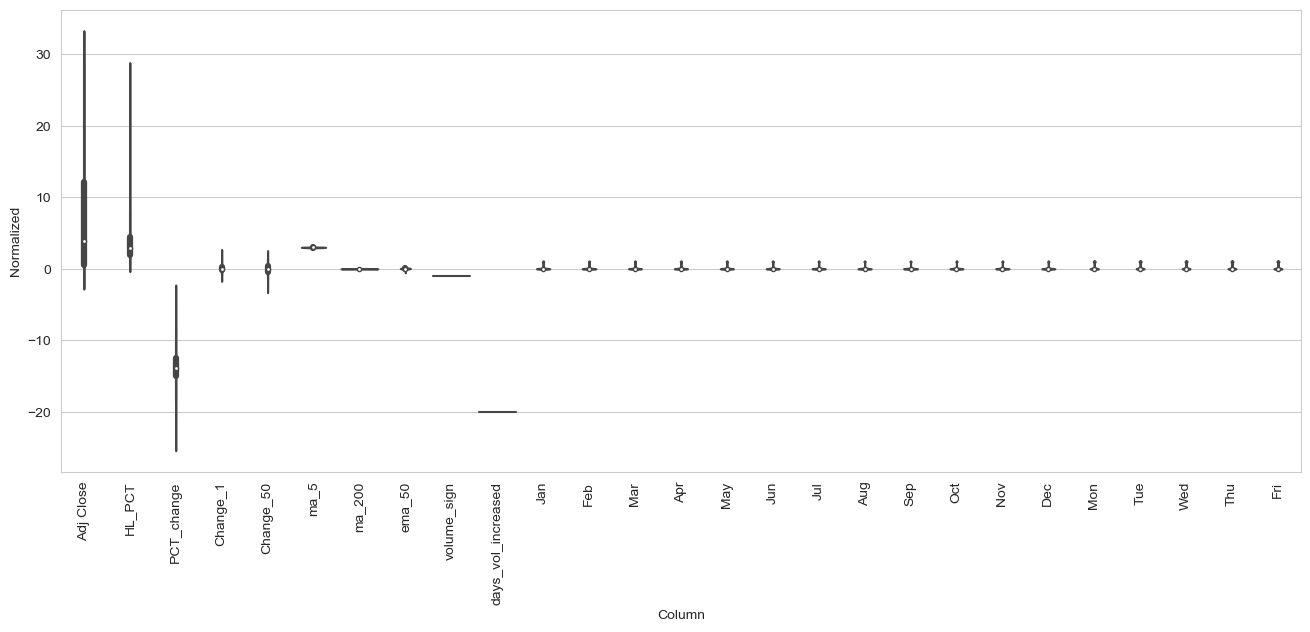

In [20]:
# Visualizing training data before scaling
df_train_melt = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_train_melt)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)
plt.show()

On the plot above we can see that the distribution of our fetures varies significantly. We should scale them.

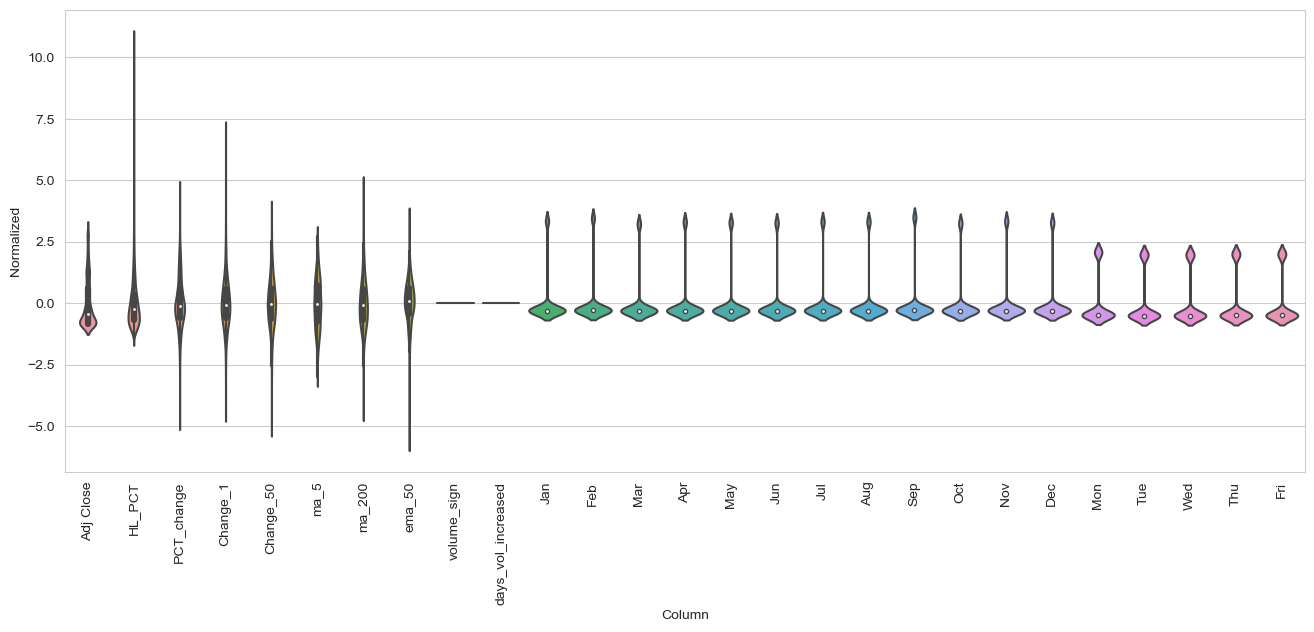

In [21]:
# Scaling
scaler = preprocessing.StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), index=df_train.index)
df_train.columns = df_new.columns

# Note: We are not fitting the scalar again
df_val = pd.DataFrame(scaler.transform(df_val), index=df_val.index)
df_val.columns = df_new.columns

# Note: We are not fitting the scalar again
df_test = pd.DataFrame(scaler.transform(df_test), index=df_test.index)
df_test.columns = df_new.columns

# Visualizing training data after scaling
df_train_std_melt = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_train_std_melt)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)
plt.show()

Now, all features have 0 mean and unit variance.

## Model Selection

### Base line model: Stock prices are the same as the year before (2020)

In [67]:
def baseline(df_train=df_train, df_val=df_val):
    """
    Initializes baseline model
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    return:
        predictions:pandas dataframe
            dataframe containing data from the previous period.

    """
    predictions = df_train.iloc[-df_val['Adj Close'].shape[0]:, :]
    
    return predictions
    
    
# get predictions
predictions_baseline = baseline()
predictions_baseline.head()

# compute errors
compute_errors(np.array(df_val['Adj Close']), np.array(predictions_baseline['Adj Close']))

MAE:  2.3194419586335817
RMSE:  2.51675670570238
MAPE: 0.6167992230724327


#### Plot

In [68]:
predictions_baseline['Adj Close'].index = df_val.index

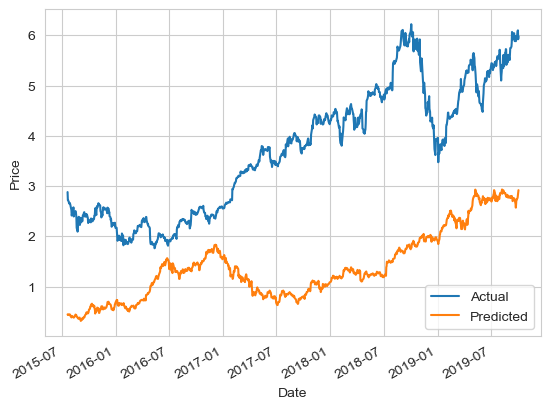

In [69]:
df_val['Adj Close'].plot(label='Actual')
predictions_baseline['Adj Close'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Conclusion: The predictions for baseline model are quite poor with a mean absolute percentage error close to 61% for Apple stock. This is expected as the stockmarket has an upward trend and most successful companies see a growth over the year. Let's see how we can make it better.

### Keep it simple, keep it linear

In [25]:
# get the number steps to predict
OUT_STEPS = int(input())

7


#### N-day forecast

In [70]:
def train_test_split_nday_forecast(df_train=df_train, df_val=df_val):
    """
    Splits both the training and validation sets into X and Y
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        X_train:ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable

    """
    
    df_temp_train = df_train.copy()
    df_temp_train['label'] = df_temp_train['Adj Close'].shift(-OUT_STEPS)
    df_temp_train = df_temp_train.dropna()

    df_temp_val = df_val.copy()
    df_temp_val['label'] = df_temp_val['Adj Close'].shift(-OUT_STEPS)
    df_temp_val =  df_temp_val.dropna()
    
    # Get X
    X_train = np.array(df_temp_train.drop(columns=['label']))
    X_val = np.array(df_temp_val.drop(columns=['label']))
    
    y_train = np.array(df_temp_train['label'])
    y_val = np.array(df_temp_val['label'])

    return X_train, X_val, y_train, y_val

##### Linear Regression

In [71]:
def linear_reg_n_day(df_train=df_train, df_val=df_val):
    """
    Initializes and fits Linear regression classfier   
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        predictions: ndarray
            predicted values
            
    """
    # Get train test data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast(df_train, df_val)
    
    # Create a classifier
    clfreg = LinearRegression()
    clfreg.fit(X_train, y_train)

    predictions = clfreg.predict(X_val)

    print(clfreg.score(X_val, y_val))
    
    compute_errors(y_val, predictions)
    
    return predictions

In [72]:
predictions = linear_reg_n_day()

0.9760033854245619
MAE:  0.14231666380900937
RMSE:  0.19682064204261918
MAPE: 0.03945250808483286


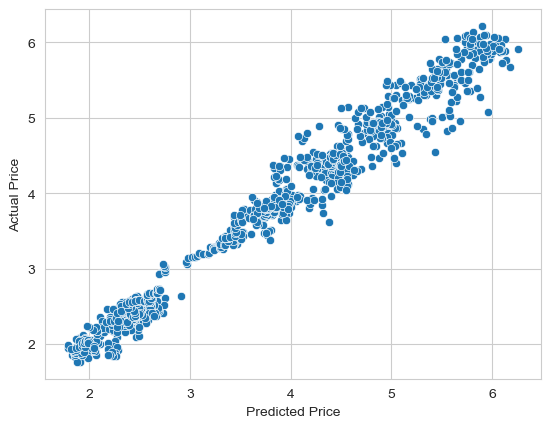

In [73]:
_, _, _, y_val = train_test_split_nday_forecast()
sns.scatterplot(x=predictions, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

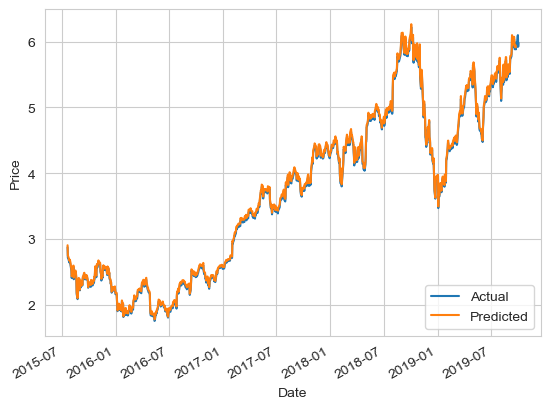

In [74]:
predictions_lin_reg = pd.DataFrame(data=predictions, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_lin_reg['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

##### Polynomial regression (n^2) 

In [31]:
def quadratic_reg_n_day(df_train=df_train, df_val=df_val):
    """
    Initializes and fits Polynimoal regression classfier 
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        predictions: ndarray
            predicted values
    """
    
    # Get train test data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast(df_train, df_val)
    
    clfpoly = make_pipeline(PolynomialFeatures(2), Ridge())
    clfpoly.fit(X_train, y_train)
    
    predictions = clfpoly.predict(X_val)

    print(clfpoly.score(X_val, y_val))
    
    compute_errors(y_val, predictions)
    
    return predictions

0.9694987599686644
MAE:  0.1690194629445604
RMSE:  0.22189851923571732
MAPE: 0.04649678257054181


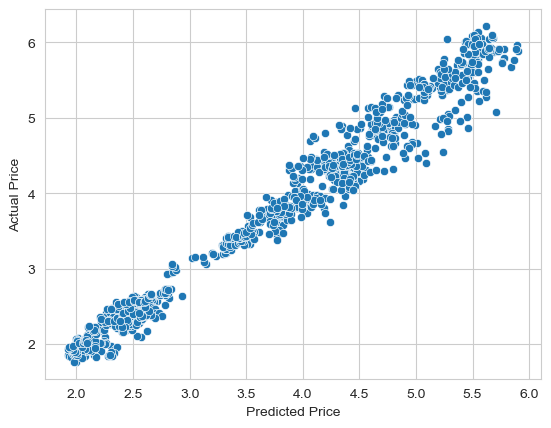

In [75]:
predictions_quad = quadratic_reg_n_day()

_, _, _, y_val = train_test_split_nday_forecast()

sns.scatterplot(x=predictions_quad, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

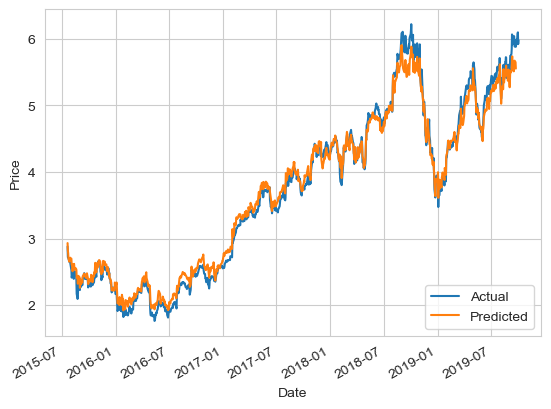

In [76]:
predictions_quad_reg = pd.DataFrame(data=predictions_quad, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_quad_reg['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Polynomial prediction looks good with 4.6% MAPE. 

### k-Nearest Neighbors

In [77]:
def get_k_knn(X_train, X_val, y_train, y_val):
    """ 
    Returns the optimal number of nearest neighbors 
    
    :params:
        X_train: ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable
        
    :return:
        n_neighbors: int
            optimal number of nearest neighbors
    """
    # genereate number of NN from 1 to 100
    k = [i for i in range(1,100)]
    mape = []
    
    # fit classifier 100 times
    for i in k:
        clfknn = KNeighborsRegressor(n_neighbors=i)
        clfknn.fit(X_train, y_train)
        predictions_knn = clfknn.predict(X_val)

        mape.append(mean_absolute_percentage_error(y_val, predictions_knn))

    # choose the optimal number of NN
    n_neighbors = mape.index(min(mape)) + 1
    
    return n_neighbors

In [78]:
def knn_n_days():
    """
    Initializes and fits k-Nearest Neighbors Classifier
    
    :params:
        None
        
    :return:
        predictions: ndarray
            predicted values
    
    """
    # get the data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast()
    
    n_neighbors = get_k_knn(X_train, X_val, y_train, y_val)
    
    # KNN Regression
    clfknn = KNeighborsRegressor(n_neighbors=n_neighbors,)
    clfknn.fit(X_train, y_train)

    # prediction
    predictions_knn = clfknn.predict(X_val)
    
    print('R2 is', clfknn.score(X_val, y_val))
    compute_errors(y_val, predictions_knn)
    
    return predictions_knn

R2 is -1.1464944160379957
MAE:  1.4810146401502187
RMSE:  1.86148927188918
MAPE: 0.3487634193893905


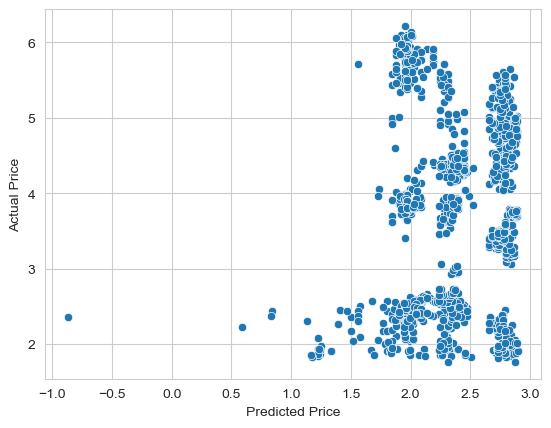

In [79]:
predictions_knn = knn_n_days()
    
sns.scatterplot(x=predictions_knn, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

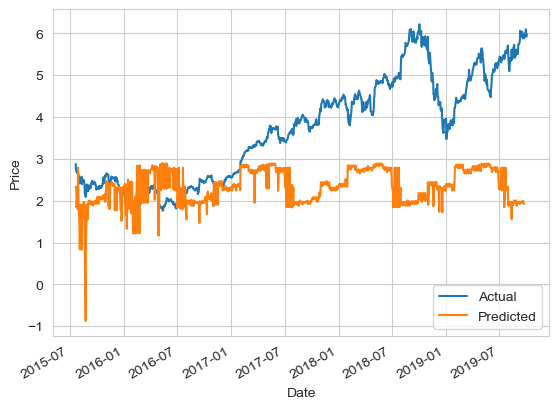

In [80]:
predictions_knn_df = pd.DataFrame(data=predictions_knn, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_knn_df['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see, metrics for KNN are much worse then those of a quadratic function. KNN failed to predict an upward trend.

---
### TensorFlow

*Source: https://www.tensorflow.org/tutorials/structured_data/time_series*

#### Data windowing 

![title](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

In [38]:
class WindowGenerator:
    """
    A class to represent a window object.

    :attr:
        input_width: int
            history size
        label_width: int
            history size
        shift: int
            prediction of 'shift' days into the future
        X_train: ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable

    methods:
        __repr__():
            Returns a string representing window object

    """
    def __init__(self, input_width, label_width, shift, data=None,
                 train_df=df_train, val_df=df_val, test_df=df_test,
                 label_columns=None):
        """
        Constructs all the necessary attributes for the Window object.

        :params:
                
        :returns:
            None
            
        """
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices
        self.label_columns = label_columns
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        if data is not None:
            self.data = data
            self.data_set = self.make_dataset(self.data)
            
        
    def __repr__(self):
        """
        Returns a string representing window object
        """
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    
    def make_dataset(self, data):
        """
        Takes a time series DataFrame and converts it to a tf.data.Dataset of (input_window, label_window) pairs 
        using the preprocessing.timeseries_dataset_from_array function

        :params:
            data: DataFrame
                time series data

        :return:
            ds: tf.data.Dataset
                time series data 

        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_window)

        return ds
    
    def split_window(self, features):
        """
        Given a list of consecutive inputs, convert them to a window of inputs and a window of labels.

        :params:
            features: tf tensor
                window object

        :return:
            inputs: tf tensor
                tensor of inputs
            labels: tf tensor
                tensor of labels
        """

        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack([
                labels[:, :, self.column_indices[name]] for name in self.label_columns
            ], axis=-1)

        # preserve the shape of the input
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


#### Create tf.data.Datasets

In [39]:
# Add properties for accessing them as tf.data.Datasets using the make_dataset method defined earlier
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)
        
        
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test



### Prediction Models

#### Baseline Model
Repeat the last input time step for the required number of output time steps

In [81]:
# Create a Window Generator object
multi_window = WindowGenerator(
    input_width=100,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['Adj Close']
)

multi_window

Total window size: 107
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100 101 102 103 104 105 106]
Label column name(s): ['Adj Close']

In [82]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    A class to represent a simple multi step baseline model.
            
    methods:
        call(inputs):
            Returns the last input time step for the required number of output time steps.
    """
    def call(self, inputs):
        """
        Returns the last input time step for the required number of output time steps.
        
        :params: tf tensor
        inputs: input to the model
        
        :return: tf tensor
            The last input time step for the required number of output time steps.
            
        """
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])


last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                     metrics=[tf.metrics.MeanAbsolutePercentageError(),
                              tf.metrics.RootMeanSquaredError(),
                              tf.metrics.MeanAbsoluteError()
                             ])

# define dictionaries to save the 
multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 1ms/step - loss: 16.9768 - mean_absolute_percentage_error: 98.1318 - root_mean_squared_error: 4.1203 - mean_absolute_error: 3.7204


#### Single-shot models: Linear
Single-shot model makes the entire sequence prediction in a single step.

In [83]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    """
    Compiles and fits the model

    :params: 
        model: tf model
            the model to be compiled and fit
        
        window: WindowGenerator 
            window object that is sent as an input to the model
        
        patience: int
            Number of epochs to wait after min has been hit. 
            After this number of no improvement, training stops.

    :return: history
        Callback that records events into a History object

    """
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=patience,
                                                      mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[
                     tf.metrics.MeanAbsolutePercentageError(),
                     tf.metrics.RootMeanSquaredError(),
                     tf.metrics.MeanAbsoluteError()
                 ])
    
    # check if we are training the full dataset or only training one
    if 'data_set' in window.__dict__:
        history = model.fit(window.data_set, epochs=MAX_EPOCHS, callbacks=[early_stopping])
    else:
        history = model.fit(window.train, epochs=MAX_EPOCHS,
                           validation_data=multi_window.val,
                           callbacks=[early_stopping])
        
    
    return history

In [84]:
# building a linear model 
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), 
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 1ms/step - loss: 0.0274 - mean_absolute_percentage_error: 3.0837 - root_mean_squared_error: 0.1657 - mean_absolute_error: 0.1200


In [88]:
print('Linear Model:', list(zip(multi_linear_model.metrics_names,multi_val_performance['Linear'])))
print()
print('Baseline Last: ', list(zip(last_baseline.metrics_names, multi_val_performance['Last'])))

Linear Model: [('loss', 0.027448948472738266), ('mean_absolute_percentage_error', 3.083691358566284), ('root_mean_squared_error', 0.1656772345304489), ('mean_absolute_error', 0.120024673640728)]

Baseline Last:  [('loss', 16.97675323486328), ('mean_absolute_percentage_error', 98.13177490234375), ('root_mean_squared_error', 4.120285987854004), ('mean_absolute_error', 3.7204318046569824)]


As we can see, Linear model does better than the baseline, but it is not great. We can try adding more Dense layers but it will still be bases on a single input time step. 

#### Single-shot models: Dense

In [89]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 2ms/step - loss: 0.0375 - mean_absolute_percentage_error: 3.8350 - root_mean_squared_error: 0.1936 - mean_absolute_error: 0.1461


In [92]:
print('Linear Model:', list(zip(multi_linear_model.metrics_names, multi_val_performance['Linear'])))
print()
print('Dense Model:', list(zip(multi_dense_model.metrics_names, multi_val_performance['Dense'])))

Linear Model: [('loss', 0.027448948472738266), ('mean_absolute_percentage_error', 3.083691358566284), ('root_mean_squared_error', 0.1656772345304489), ('mean_absolute_error', 0.120024673640728)]

Dense Model: [('loss', 0.037479523569345474), ('mean_absolute_percentage_error', 3.8350236415863037), ('root_mean_squared_error', 0.19359628856182098), ('mean_absolute_error', 0.14610950648784637)]


Interestingly, Dense model did not perform better than the linear model though the results are not far apart. Let's see if CNN can do better.

#### Single-shot model: CNN

In [93]:
%%time

multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(3)),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 1ms/step - loss: 0.0339 - mean_absolute_percentage_error: 3.5960 - root_mean_squared_error: 0.1842 - mean_absolute_error: 0.1362
CPU times: user 20.1 s, sys: 6.58 s, total: 26.7 s
Wall time: 6.66 s


In [97]:
print('Dense Model:', list(zip(multi_dense_model.metrics_names, multi_val_performance['Dense'])))
print()
print('CNN Model:', list(zip(multi_conv_model.metrics_names, multi_val_performance['Conv'])))

Dense Model: [('loss', 0.037479523569345474), ('mean_absolute_percentage_error', 3.8350236415863037), ('root_mean_squared_error', 0.19359628856182098), ('mean_absolute_error', 0.14610950648784637)]

CNN Model: [('loss', 0.03393235057592392), ('mean_absolute_percentage_error', 3.596027374267578), ('root_mean_squared_error', 0.18420736491680145), ('mean_absolute_error', 0.13620838522911072)]


CNN performed approximately the same way as the Dense model. Let's see if we can improve the prediction by using RNN.

#### Single-shot model: RNN

In [98]:
%%time

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 8ms/step - loss: 2.2471 - mean_absolute_percentage_error: 26.7076 - root_mean_squared_error: 1.4990 - mean_absolute_error: 1.1915
CPU times: user 1min 14s, sys: 18.3 s, total: 1min 32s
Wall time: 35.7 s


In [99]:
print('CNN Model:', list(zip(multi_conv_model.metrics_names, multi_val_performance['Conv'])))
print()
print('LSTM Model:', list(zip(multi_lstm_model.metrics_names, multi_val_performance['LSTM'])))

CNN Model: [('loss', 0.03393235057592392), ('mean_absolute_percentage_error', 3.596027374267578), ('root_mean_squared_error', 0.18420736491680145), ('mean_absolute_error', 0.13620838522911072)]

LSTM Model: [('loss', 2.247058629989624), ('mean_absolute_percentage_error', 26.70757484436035), ('root_mean_squared_error', 1.4990193843841553), ('mean_absolute_error', 1.1914681196212769)]


Wow, surprosingly, RNN performed significantly worse. This was a single-shot model. Let's see if autoregressive model can help us. 

#### Autoregressive: RNN

In [100]:
class FeedBack(tf.keras.Model):
    """
    Class for Autoregressive RNN model
    """
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [101]:
def warmup(self, inputs):
    """
    Method to initialize its internal state based on the inputs. 
    Once trained, this state will capture the relevant parts of the input history. 
    This is equivalent to the single-step LSTM model from earlier.
    
    :returns: 
        prediction: tf tensor
            predictions.shape => (batch, features)
            single time-step prediction 

        state:
            internal state of LSTM model
            
    """
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    
    return prediction, state

FeedBack.warmup = warmup

In [102]:
def call(self, inputs, training=None):
    """
    Method for iterating the model feeding the predictions at each step back as the input 
    and collecting the output predictions
    
    :returns: 
        prediction: tf tensor
        predictions.shape => (batch, time, features)
        predictions 

    """
    predictions = []
    
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)
    
    for n in range(1, self.out_steps):
        x = prediction
        x, state= self.lstm_cell(x, states=state, training=training)
        
        prediction = self.dense(x)
        predictions.append(prediction)
        
    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    return predictions


FeedBack.call = call

In [103]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(feedback_model)


30/30 [==============================] - 0s 7ms/step - loss: 2.4900 - mean_absolute_percentage_error: 27.1593 - root_mean_squared_error: 1.5780 - mean_absolute_error: 1.2416
CPU times: user 52.2 s, sys: 12.8 s, total: 1min 4s
Wall time: 24.3 s


In [104]:
print('CNN Model:', list(zip(multi_conv_model.metrics_names, multi_val_performance['Conv'])))
print()
print('RNN Model:', list(zip(multi_lstm_model.metrics_names, multi_val_performance['LSTM'])))
print()
print('AR RNN Model:', list(zip(feedback_model.metrics_names, multi_val_performance['AR LSTM'])))
print()




CNN Model: [('loss', 0.03393235057592392), ('mean_absolute_percentage_error', 3.596027374267578), ('root_mean_squared_error', 0.18420736491680145), ('mean_absolute_error', 0.13620838522911072)]

RNN Model: [('loss', 2.247058629989624), ('mean_absolute_percentage_error', 26.70757484436035), ('root_mean_squared_error', 1.4990193843841553), ('mean_absolute_error', 1.1914681196212769)]

AR RNN Model: [('loss', 2.4900355339050293), ('mean_absolute_percentage_error', 27.159265518188477), ('root_mean_squared_error', 1.5779846906661987), ('mean_absolute_error', 1.2415727376937866)]



Well, autoregressive model didn't help. Let's see the overall result:

#### Performance

In [71]:
multi_performance

{'Last': [189.9339599609375, 12.940163612365723],
 'Linear': [0.6062445640563965, 0.6432307362556458],
 'Dense': [4.987715721130371, 2.112454652786255],
 'Conv': [7.045191764831543, 2.5283970832824707],
 'LSTM': [143.31951904296875, 11.574179649353027],
 'AR LSTM': [176.45437622070312, 12.87997055053711]}

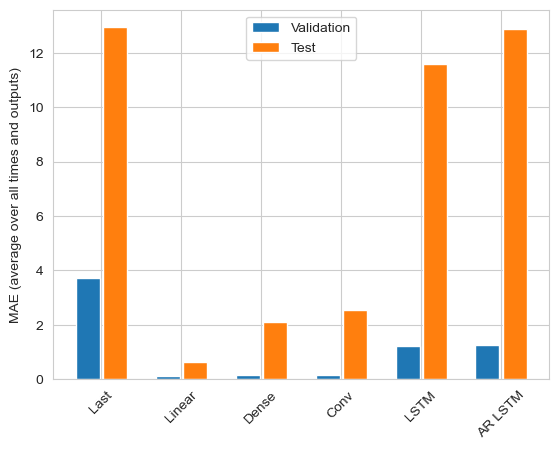

In [72]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

plt.show()

***Conclusion: (BASED ON MULTIPLE OBESRVATIONS)***: According to my observations, both of the LSTM models significantly underperform on a continuous basis. Liner model is very unstable and depends a lot on the stack. CNN seems and Dense models seem to perform approximately the same. I decided to procees with the CNN model as I believe it should be able to catch particularities of data better than the Dense model. 

### Re-train CNN Model on all data

In [74]:
df_scaled = pd.DataFrame(scaler.fit_transform(df_new), index=df_new.index)
df_scaled.columns = df_new.columns

multi_window_full = WindowGenerator(
    input_width=100,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    data=df_scaled,
    label_columns=['Adj Close']
)

history = compile_and_fit(multi_conv_model, multi_window_full)

IPython.display.clear_output()

In [75]:
# Make predictions and rescale them
predictions = multi_conv_model.predict(multi_window.test)
forecast = scaler.inverse_transform(predictions)
forecast.shape

(424, 7, 27)

In [76]:
# check the 7 day forecast value
forecast[-1, :, 0]

array([498.50952, 496.91168, 490.24353, 488.99246, 488.5482 , 491.7108 ,
       492.32968], dtype=float32)

In [77]:
df[-7:]['Adj Close']

Date
2021-10-28    152.347656
2021-10-29    149.581696
2021-11-01    148.742920
2021-11-02    149.801376
2021-11-03    151.269241
2021-11-04    150.740005
2021-11-05    151.279999
Name: Adj Close, dtype: float64

In [78]:
forecast[-1:, :, 0]

array([[498.50952, 496.91168, 490.24353, 488.99246, 488.5482 , 491.7108 ,
        492.32968]], dtype=float32)

In [193]:
# Save the model
multi_conv_model.save('conv_model')

INFO:tensorflow:Assets written to: conv_model/assets
